<a href="https://colab.research.google.com/github/Yzyz-99/DL_Model/blob/main/Covid-19%20Prediction%20Model/COVID_19_Cases_Prediction_(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

In [3]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Data processing
import numpy as np
import csv
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42029 # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

In [4]:
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train'])// len(loss_record['dev'])]
  figure(figsize=(6,4))
  plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
  plt.ylim(0.0, 5.)
  plt.xlabel('Training steps')
  plt.ylabel('MSE loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

def plot_pred(dv_set, model, device, lim=35, preds=None, targets=None):
  if preds is None or targets is None:
    model.eval()
    preds, targets = [], []
    for x, y in dv_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred=model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
  
  figure(figsize=(5,5))
  plt.scatter(targets, preds, c='r', alpha=0.5)
  plt.plot([-0.2, lim], [-0.2, lim], c='b')
  plt.xlim(-0.2, lim)
  plt.ylim(-0.2, lim)
  plt.xlabel('ground truth value')
  plt.ylabel('predicted value')
  plt.title('Ground Truth V.S. Prediction')
  plt.show()

In [5]:
class COVID19Dataset(Dataset):
  def __init__(self, path, mode='train', target_only=False):
    self.mode=mode
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)

    if not target_only:
      feats = list(range(93))
    else:
      feats = list(range(1, 40)) + [57, 75]
    
    if mode == 'test':
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    
    else:
      target = data[:, -1]
      data = data[:, feats]

      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]

      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])
    
    self.data[:, 40:] = \
      (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
      / self.data[:, 40:].std(dim=0, keepdim=True)

    self.dim = self.data.shape[1]

    print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
          .format(mode, len(self.data), self.dim))
    
  def __getitem__(self, index):
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]

  def __len__(self):
    return len(self.data)

In [6]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(dataset, batch_size, shuffle=(mode=='train'),
                          drop_last=False, num_workers=n_jobs, pin_memory=True)
  return dataloader

In [7]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim):
    super(NeuralNet, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64,1)
    )

    self.criterion = nn.MSELoss(reduction='mean')

  def forward(self, x):
    return self.net(x).squeeze(1)

  def cal_loss(self, pred, target):
    regularization_loss = 0
    for param in model.parameters():
      # TODO: you may implement L1/L2 regularization here
      # 使用L2正则项
      # regularization_loss += torch.sum(abs(param))
      regularization_loss += torch.sum(param ** 2)
    return self.criterion(pred, target) + 0.00075 * regularization_loss

In [8]:
def train(tr_set, dv_set, model, config, device):
  n_epochs = config['n_epochs']

  # Setup optimizer
  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])

  min_mse = 1000
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt = 0
  epoch = 0

  while epoch < n_epochs:
    model.train()
    for x, y in tr_set:
      optimizer.zero_grad()
      x,y = x.to(device), y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward()
      optimizer.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())

    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epoch = {:4d}, loss = {:4f})'
            .format(epoch+1, min_mse))
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt +=1

    epoch+=1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break;

  print('Finish training after {} epochs'.format(epoch))
  return min_mse, loss_record

In [9]:
def dev(dv_set, model, device):
  model.eval()
  total_loss = 0
  for x, y in dv_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
    total_loss += mse_loss.detach().cpu().item() * len(x)
  total_loss = total_loss/len(dv_set.dataset)
  
  return total_loss

In [10]:
def test(tt_set, model, device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds, dim=0).numpy()
  return preds

In [11]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = True

config ={
    'n_epochs': 3000,
    'batch_size': 270,
    'optimizer': 'SGD',
    'optim_hparas':{
        'lr': 0.001,
        'momentum': 0.9
    },
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

In [12]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 41)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 41)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 41)


In [13]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [14]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 2.208721)
Saving model (epoch =    9, loss = 2.128921)
Saving model (epoch =   10, loss = 2.110929)
Saving model (epoch =   11, loss = 2.101597)
Saving model (epoch =   12, loss = 2.099211)
Saving model (epoch =   15, loss = 2.092969)
Saving model (epoch =   17, loss = 2.083263)
Saving model (epoch =   18, loss = 2.081938)
Saving model (epoch =   20, loss = 2.078972)
Saving model (epoch =   25, loss = 2.076951)
Saving model (epoch =   32, loss = 2.056265)
Saving model (epoch =   33, loss = 2.049537)
Saving model (epoch =   38, loss = 2.036706)
Saving model (epoch =   40, loss = 2.027541)
Saving model (epoch =   41, loss = 2.023217)
Saving model (epoch =   42, loss = 2.022080)
Saving model (epoch =   45, loss = 2.021143)
Saving model (epoch =   47, loss = 2.012620)
Saving model (epoch =   51, loss = 2.001452)
Saving model (epoch =   55, loss = 1.995793)
Saving model (epoch =   60, loss = 1.984473)
Saving model (epoch =   61, loss = 1.971958)
Saving mod

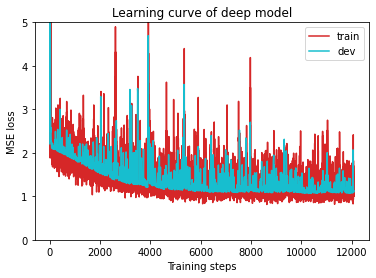

In [15]:
plot_learning_curve(model_loss_record, title='deep model')

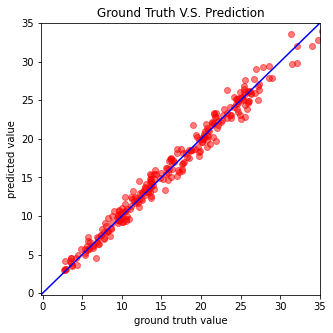

In [16]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

In [18]:
def save_pred(preds, file):
  print('Saving result to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])
    
preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving result to pred.csv
